#Sequencing Success: A Hands-On Workshop in Deep Learning for Sequence-to-Sequence Models
Moratuwa Engineering Research Conference 2023 (MERCon 2023) is the 9th international conference organized by the Engineering Research Unit at the University of Moratuwa. As part of MERCon 2023, we are hosting a Hands-On Workshop on Deep Learning for Sequence-to-Sequence Models. This workshop spans four hours and is divided into four one-hour sessions, covering the following topics:
- Introduction to Sequence-to-Sequence Learning
- Sequence-to-Sequence Learning with Recurrent Neural Networks (RNNs)
- Sequence-to-Sequence Learning with Encoder-Decoder Models
- Sequence-to-Sequence Learning with Encoder-Decoder Models and Attention Mechanisms

This notebook is prepared for session **Sequence-to-Sequence Learning with Recurrent Neural Networks**.

All rights reserved.

Authors:
1.   Dr.T.Uthayasanker ([rtuthaya.lk](https://rtuthaya.lk))
2.   Mr.S.Braveenan ([Braveenan Sritharan](https://www.linkedin.com/in/braveenan-sritharan/))

[For more information - MERCon 2023](https://mercon.uom.lk)

#A Simple Seq2Seq Problem 2: The reverse sentence problem
In this simple Seq2Seq problem, we are provided with a **parallel dataset** comprising two sentences, X (input) and y (output). In this scenario, the output sentence, y[i], is constructed by reversing the order of the words in the input sentence, X[i]. To illustrate, consider an example where the **input sentence X[i]** has a length of 6, such as:

X[i] = **he ate apple**

The corresponding **output sentence, y[i]**, would be:

y[i] = **apple ate he**

This problem serves as a foundational example of a Sequence-to-Sequence (Seq2Seq) task, where the objective is to learn to reverse sentences effectively.

In [1]:
#@title Import Libraries
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import Input
from keras.layers import RepeatVector, Dense, SimpleRNN, GRU, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential, Model

#Auxiliary functions

Certainly! Here's a more concise introduction to the key functions in the code snippet:
1. **generate_text_sequence(length, word_array)**: Generates a random text sequence of a given length using words from an array.
2. **one_hot_encode_text(text_sequence, word_array)**: Converts a text sequence into one-hot encoded vectors using a word array.
3. **one_hot_decode_text(encoded_seq, word_array)**: Decodes a one-hot encoded sequence back into its original text form.
4. **get_reversed_pairs(time_steps, word_array, verbose=False)**: Generates pairs of random sequences and their reversals, one-hot encodes them, and returns them for training.
5. **create_dataset(train_size, test_size, time_steps, word_array, verbose=False)**: Creates training and testing datasets by generating reversed pairs.
6. **train_test(model, X_train, y_train, X_test, y_test, epochs=100, verbose=0)**: Trains a neural network model, evaluates it, and returns the model and training history.
7. **visualize_history(history)**: Visualizes the training history, showing accuracy and loss over epochs.
8. **check_samples(model, X_test, y_test, word_array, num_samples=10)**: Checks the model's performance on a set of sample sequences from the testing data.

These functions collectively support the process of training and evaluating a neural network for a sentence reversal task.

In [2]:
#@title Function to generate a text sequence
# generate sequence
def generate_text_sequence(length, word_array):
    word_sequence = [random.choice(word_array) for _ in range(length)]
    text_sequence = ' '.join(word_sequence)
    return text_sequence

In [3]:
#@title Function to encode and decode text sequence
# one hot encode sequence
def one_hot_encode_text(text_sequence, word_array):
    encoding = []
    for word in text_sequence.split():
        vector = [0] * len(word_array)
        if word in word_array:
            vector[word_array.index(word)] = 1
        encoding.append(vector)
    return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode_text(encoded_seq, word_array):
    decoded_sequence = [word_array[np.argmax(vector)] for vector in encoded_seq]
    return ' '.join(decoded_sequence)

In [4]:
#@title Function to generate reverse pair dataset
# create one reverse pair
def get_reversed_pairs(time_steps,word_array,verbose= False):
		# generate random sequence
		sequence_in = generate_text_sequence(time_steps, word_array)
		sequence_out = ' '.join(sequence_in.split()[::-1])

		# one hot encode
		X = one_hot_encode_text(sequence_in, word_array)
		y = one_hot_encode_text(sequence_out, word_array)
		# reshape as 3D
		X = X.reshape((1, X.shape[0], X.shape[1]))
		y = y.reshape((1, y.shape[0], y.shape[1]))

		if(verbose):
			print('\nSample X and y')
			print('\nIn raw format:')
			print('X[0]=%s, y[0]=%s' % (one_hot_decode_text(X[0], word_array), one_hot_decode_text(y[0], word_array)))
			print('\nIn one_hot_encoded format:')
			print('X[0]=%s' % (X[0]))
			print('y[0]=%s' % (y[0]))
		return X,y

# create final dataset
def create_dataset(train_size, test_size, time_steps,word_array, verbose= False):
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(train_size)]
		pairs=np.array(pairs).squeeze()
		X_train = pairs[:,0]
		y_train = pairs[:,1]
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(test_size)]
		pairs=np.array(pairs).squeeze()
		X_test = pairs[:,0]
		y_test = pairs[:,1]

		if(verbose):
			print('\nGenerated sequence datasets as follows')
			print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
			print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

		return X_train, y_train, X_test, 	y_test

In [5]:
#@title Function to train and evaluate model
def train_test(model, X_train, y_train , X_test, y_test, epochs=100, verbose=0):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # train model
    print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    return model, history.history

In [6]:
#@title Function to visualize loss and accuracy
def visualize_history(history):
	# summarize history for accuracy
	plt.plot(history['accuracy'])
	plt.plot(history['val_accuracy'])
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history['loss'])
	plt.plot(history['val_loss'])
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

In [7]:
#@title Function to check some examples
def check_samples(model, X_test, y_test, word_array, num_samples=10):
    sample_indices = random.sample(range(len(X_test)), num_samples)

    for id in sample_indices:
        X, y = X_test[id], y_test[id]
        X = np.expand_dims(X, axis=0)
        y = np.expand_dims(y, axis=0)
        yhat = model.predict(X, verbose=0)
        print(f"Input: {one_hot_decode_text(X[0], word_array)} \nExpected: {one_hot_decode_text(y[0], word_array)} \nPredicted: {one_hot_decode_text(yhat[0], word_array)} \n{np.array_equal(one_hot_decode_text(y[0], word_array), one_hot_decode_text(yhat[0], word_array))}\n")

#Create reverse sentence dataset


This code snippet is designed to generate a dataset for the **Reverse Sentence Task**. In this task, each data point consists of a sentence and its reversed counterpart. The essential parameters include the input sequence length (n_timesteps_in), the number of unique words (n_features), the size of the training dataset (train_size), and the size of the testing dataset (test_size).

The code accomplishes the following:
1. It generates a random sentence and its reversed version, one-hot encodes them, and optionally displays sample pairs of sentences to illustrate the dataset structure.
2. The code then creates training and testing datasets by generating pairs of random sentences and their reversals. The dataset sizes are determined by the parameters train_size and test_size.

This dataset is a crucial component for training and evaluating models for the **Reverse Sentence Task**, which is a common problem in natural language processing.

In [8]:
word_array = ["apple", "banana", "cherry", "orange", "strawberry",
             "carrot", "broccoli", "potato", "tomato", "cucumber",
             "rose", "tulip", "daisy", "lily", "sunflower",
             "red", "blue", "green", "yellow", "purple",
             "Colombo", "London", "Paris", "Tokyo", "Sydney",
             "car", "bus", "bicycle", "train", "motorcycle",
             "guitar", "piano", "violin", "trumpet", "flute",
             "beach", "mountain", "park", "desert", "island",
             "book", "computer", "chair", "table", "lamp",
             "dog", "cat", "bird", "elephant", "lion"]

In [9]:
#@title Generating dataset
# Default configuration parameters
n_timesteps_in = 6
n_features = len(word_array)
train_size = 20000
test_size = 200

# Generate random sequence using specified parameters
X, y = get_reversed_pairs(n_timesteps_in, word_array, verbose=True)

# Generate datasets using specified parameters
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in, word_array, verbose=True)


Sample X and y

In raw format:
X[0]=Colombo blue purple table apple carrot, y[0]=carrot apple table purple blue Colombo

In one_hot_encoded format:
X[0]=[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
y[0]=[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#1. Multi-Layer Perceptron network model

Model: "model_Multi_Layer_Perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 6, 128)         │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6, 50)          │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,034 (70.45 KB)

 Trainable params: 18,034 (70.45 KB)

 Non-trainable params: 0 (0.00 B)

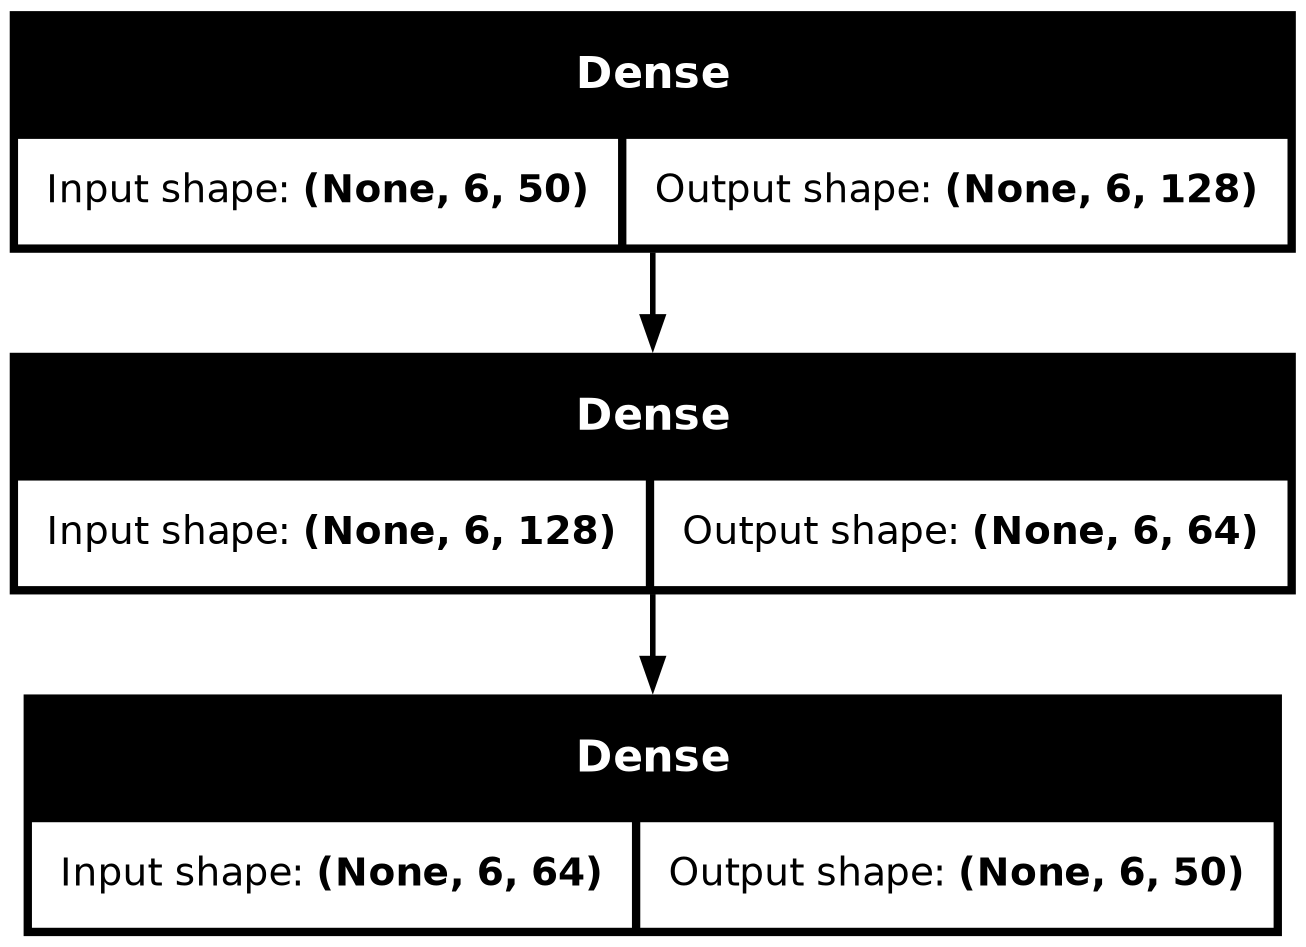

In [38]:
#@title Create Multi-Layer Perceptron network model
numberOfPerceptrons=64
model_Multi_Layer_Perceptron = Sequential(name='model_Multi_Layer_Perceptron')
model_Multi_Layer_Perceptron.add(Input(shape=(n_timesteps_in, n_features)))
model_Multi_Layer_Perceptron.add(Dense(2*numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(n_features, activation='softmax'))

model_Multi_Layer_Perceptron.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Multi_Layer_Perceptron.summary()
plot_model(model_Multi_Layer_Perceptron,show_shapes=True)

In [39]:
#@title Train and Evaluate Multi-Layer Perceptron network model
trained_model_mlp, history_mlp = train_test(model_Multi_Layer_Perceptron, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 4s - 7ms/step - accuracy: 0.0210 - loss: 3.9173 - val_accuracy: 0.0188 - val_loss: 3.9156
Epoch 2/100
563/563 - 3s - 5ms/step - accuracy: 0.0230 - loss: 3.9113 - val_accuracy: 0.0218 - val_loss: 3.9167
Epoch 3/100
563/563 - 2s - 4ms/step - accuracy: 0.0229 - loss: 3.9096 - val_accuracy: 0.0206 - val_loss: 3.9171
Epoch 4/100
563/563 - 3s - 4ms/step - accuracy: 0.0243 - loss: 3.9088 - val_accuracy: 0.0202 - val_loss: 3.9175
Epoch 5/100
563/563 - 3s - 4ms/step - accuracy: 0.0241 - loss: 3.9082 - val_accuracy: 0.0189 - val_loss: 3.9181
Epoch 6/100
563/563 - 3s - 5ms/step - accuracy: 0.0245 - loss: 3.9077 - val_accuracy: 0.0189 - val_loss: 3.9182
Epoch 7/100
563/563 - 3s - 4ms/step - accuracy: 0.0236 - loss: 3.9076 - val_accuracy: 0.0206 - val_loss: 3.9182
Epoch 8/100
563/563 - 2s - 4ms/step - accuracy: 0.0237 - loss: 3.9075 - val_accuracy: 0.0207 - val_loss:

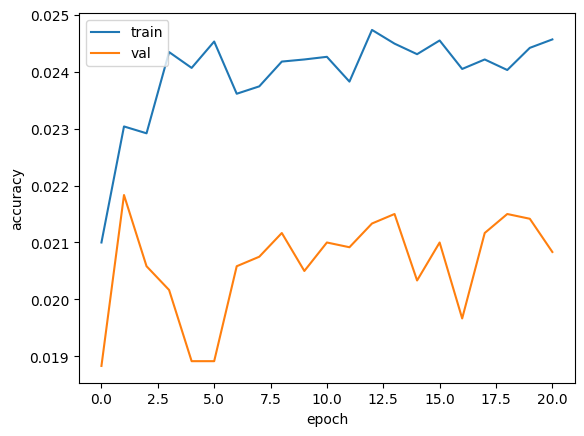

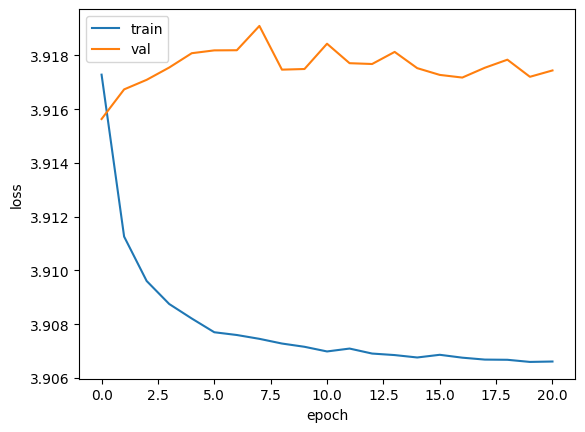

In [40]:
#@title Visualize training and validation Multi-Layer Perceptron network model
visualize_history(history_mlp)

In [41]:
#@title Check random samples Multi-Layer Perceptron network model
check_samples(trained_model_mlp, X_test, y_test, word_array, num_samples=10)

Input: cat sunflower guitar banana cherry Sydney 
Expected: Sydney cherry banana guitar sunflower cat 
Predicted: lily bicycle guitar book orange yellow 
False

Input: cucumber piano table lion computer desert 
Expected: desert computer lion table piano cucumber 
Predicted: orange bird carrot computer lion Paris 
False

Input: London elephant Tokyo bird sunflower rose 
Expected: rose sunflower bird Tokyo elephant London 
Predicted: bicycle broccoli Tokyo piano bicycle computer 
False

Input: bus Tokyo lion beach table London 
Expected: London table beach lion Tokyo bus 
Predicted: car Tokyo computer computer carrot bicycle 
False

Input: bus guitar Tokyo computer tulip cherry 
Expected: cherry tulip computer Tokyo guitar bus 
Predicted: car guitar Tokyo lion mountain orange 
False

Input: desert guitar yellow cucumber motorcycle motorcycle 
Expected: motorcycle motorcycle cucumber yellow guitar desert 
Predicted: Paris guitar Sydney orange park park 
False

Input: desert bus lily green

#2. Recurrent Neural Networks

#2.1. Simple Recurrent Neural Network model (RNN)

Model: "model_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 6, 64)          │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 6, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 6, 50)          │         3,250 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,866 (73.70 KB)

 Trainable params: 18,866 (73.70 KB)

 Non-trainable params: 0 (0.00 B)

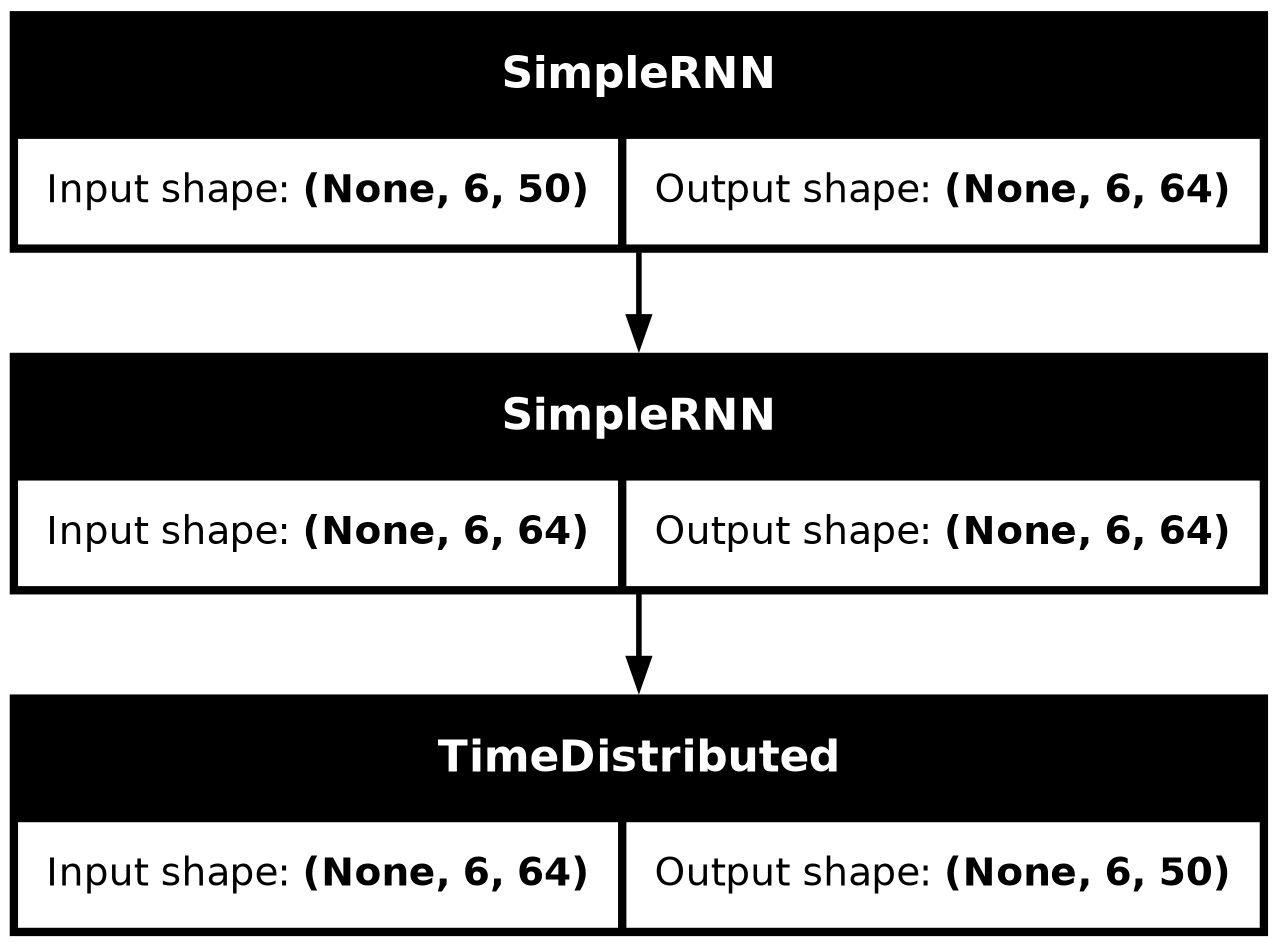

In [42]:
#@title Create simple RNN model
numberOfUnits = 64
model_RNN = Sequential(name='model_RNN')
model_RNN.add(Input(shape=(n_timesteps_in, n_features)))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()
plot_model(model_RNN, show_shapes=True)

In [43]:
#@title Train and Evaluate simple RNN model
trained_model_rnn, history_rnn = train_test(model_RNN, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 7s - 12ms/step - accuracy: 0.2679 - loss: 3.1067 - val_accuracy: 0.3260 - val_loss: 2.8285
Epoch 2/100
563/563 - 3s - 5ms/step - accuracy: 0.3322 - loss: 2.7451 - val_accuracy: 0.3376 - val_loss: 2.7154
Epoch 3/100
563/563 - 3s - 5ms/step - accuracy: 0.3385 - loss: 2.6665 - val_accuracy: 0.3408 - val_loss: 2.6681
Epoch 4/100
563/563 - 3s - 5ms/step - accuracy: 0.3413 - loss: 2.6295 - val_accuracy: 0.3392 - val_loss: 2.6472
Epoch 5/100
563/563 - 3s - 5ms/step - accuracy: 0.3415 - loss: 2.6078 - val_accuracy: 0.3402 - val_loss: 2.6311
Epoch 6/100
563/563 - 3s - 5ms/step - accuracy: 0.3430 - loss: 2.5920 - val_accuracy: 0.3411 - val_loss: 2.6210
Epoch 7/100
563/563 - 3s - 6ms/step - accuracy: 0.3434 - loss: 2.5799 - val_accuracy: 0.3423 - val_loss: 2.6108
Epoch 8/100
563/563 - 3s - 6ms/step - accuracy: 0.3571 - loss: 2.5341 - val_accuracy: 0.3766 - val_loss

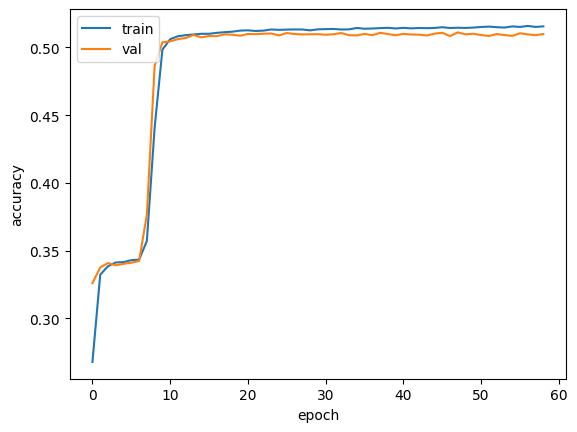

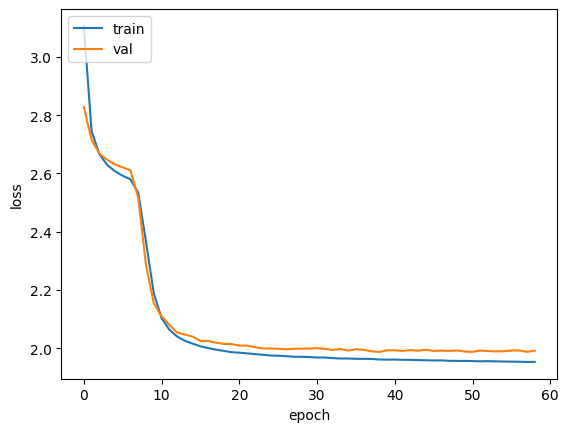

In [44]:
#@title Visualize training and validation simple RNN model
visualize_history(history_rnn)

In [45]:
#@title Check random samples simple RNN model
check_samples(trained_model_rnn, X_test, y_test, word_array, num_samples=10)

Input: blue apple orange motorcycle sunflower blue 
Expected: blue sunflower motorcycle orange apple blue 
Predicted: strawberry red blue orange apple blue 
False

Input: trumpet Paris cat book island dog 
Expected: dog island book cat Paris trumpet 
Predicted: cucumber red beach cat Paris trumpet 
False

Input: bicycle chair beach chair purple lion 
Expected: lion purple chair beach chair bicycle 
Predicted: Paris lion motorcycle beach chair bicycle 
False

Input: island red car train cat beach 
Expected: beach cat train car red island 
Predicted: lion cherry lion car red island 
False

Input: cucumber piano table lion computer desert 
Expected: desert computer lion table piano cucumber 
Predicted: violin London rose table piano cucumber 
False

Input: cat sunflower guitar banana cherry Sydney 
Expected: Sydney cherry banana guitar sunflower cat 
Predicted: daisy tulip book guitar sunflower cat 
False

Input: dog tulip bird Sydney island tomato 
Expected: tomato island Sydney bird tul

#2.2. Gated Recurrent Units model (GRU)

Model: "model_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 6, 64)          │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 6, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 6, 50)          │         3,250 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,482 (197.20 KB)

 Trainable params: 50,482 (197.20 KB)

 Non-trainable params: 0 (0.00 B)

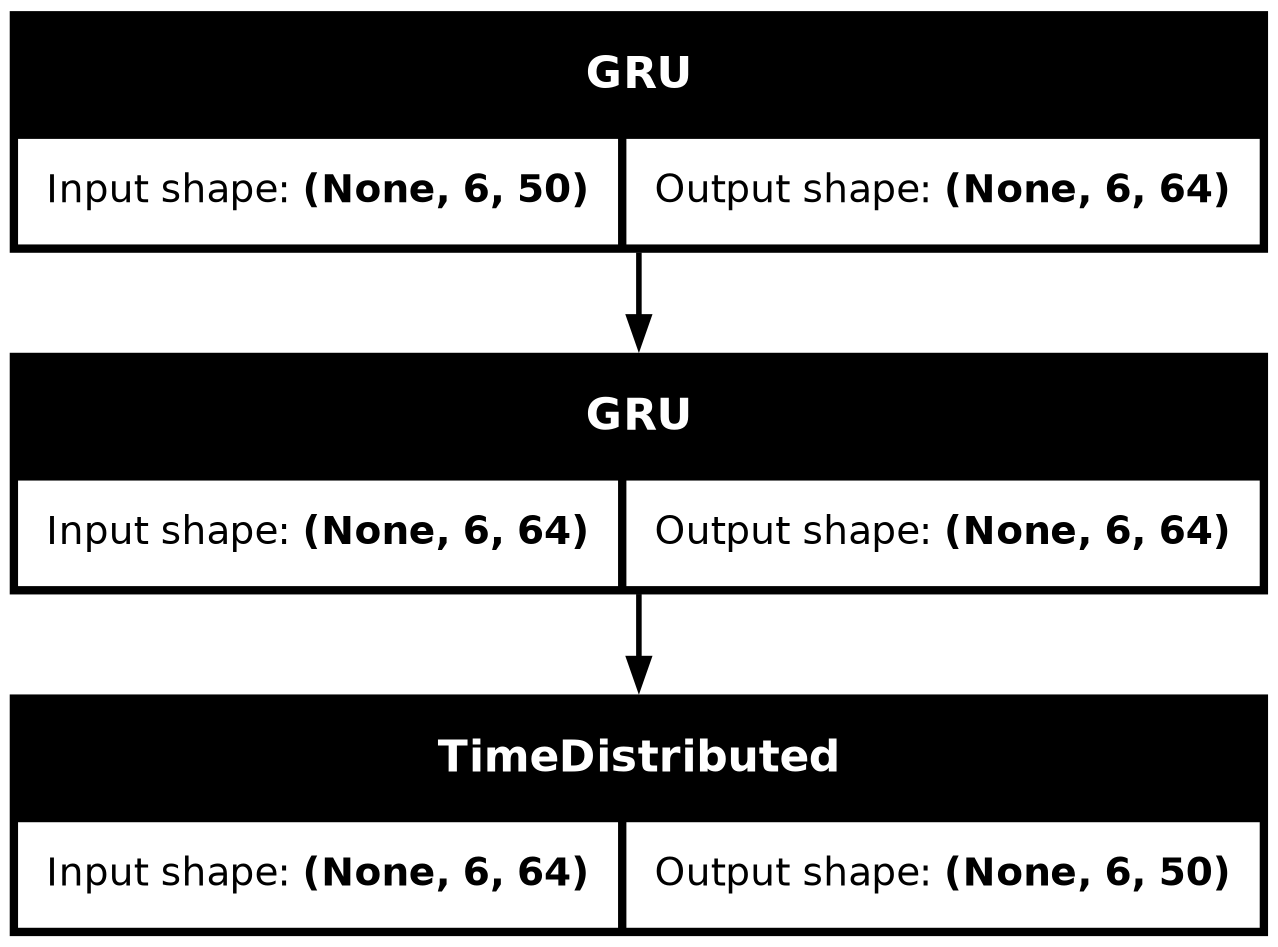

In [46]:
#@title Create GRU model
numberOfUnits = 64
model_GRU = Sequential(name='model_GRU')
model_GRU.add(Input(shape=(n_timesteps_in, n_features)))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()
plot_model(model_GRU, show_shapes=True)

In [47]:
#@title Train and Evaluate GRU model
trained_model_gru, history_gru = train_test(model_GRU, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 10s - 18ms/step - accuracy: 0.1412 - loss: 3.3103 - val_accuracy: 0.1756 - val_loss: 2.9925
Epoch 2/100
563/563 - 5s - 9ms/step - accuracy: 0.1883 - loss: 2.8929 - val_accuracy: 0.1985 - val_loss: 2.8213
Epoch 3/100
563/563 - 5s - 9ms/step - accuracy: 0.2346 - loss: 2.7313 - val_accuracy: 0.3006 - val_loss: 2.6186
Epoch 4/100
563/563 - 6s - 10ms/step - accuracy: 0.3698 - loss: 2.4651 - val_accuracy: 0.4141 - val_loss: 2.3677
Epoch 5/100
563/563 - 5s - 9ms/step - accuracy: 0.4557 - loss: 2.2376 - val_accuracy: 0.4677 - val_loss: 2.1935
Epoch 6/100
563/563 - 5s - 10ms/step - accuracy: 0.4898 - loss: 2.1077 - val_accuracy: 0.4947 - val_loss: 2.0884
Epoch 7/100
563/563 - 5s - 9ms/step - accuracy: 0.5035 - loss: 2.0402 - val_accuracy: 0.5037 - val_loss: 2.0377
Epoch 8/100
563/563 - 5s - 10ms/step - accuracy: 0.5081 - loss: 2.0060 - val_accuracy: 0.5062 - val_

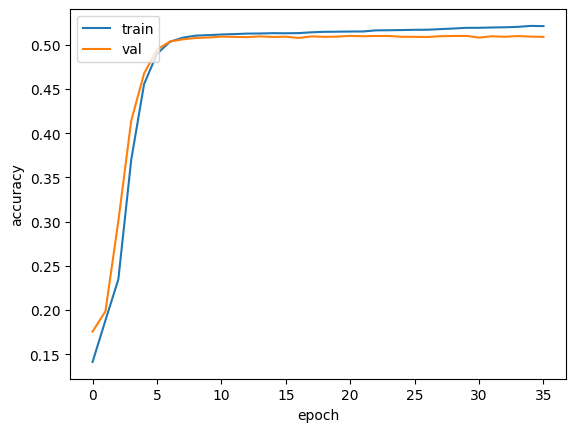

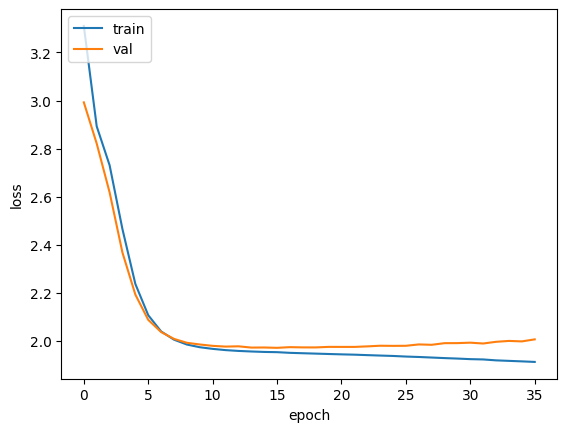

In [48]:
#@title Visualize training and validation GRU model
visualize_history(history_gru)

In [49]:
#@title Check random samples GRU model
check_samples(trained_model_gru, X_test, y_test, word_array, num_samples=10)

Input: blue apple orange motorcycle sunflower blue 
Expected: blue sunflower motorcycle orange apple blue 
Predicted: guitar carrot tomato orange apple blue 
False

Input: purple orange tomato bicycle potato Sydney 
Expected: Sydney potato bicycle tomato orange purple 
Predicted: park table flute tomato orange purple 
False

Input: red broccoli cucumber desert lamp Tokyo 
Expected: Tokyo lamp desert cucumber broccoli red 
Predicted: bird elephant bus cucumber broccoli red 
False

Input: tomato computer piano cherry violin computer 
Expected: computer violin cherry piano computer tomato 
Predicted: guitar Paris cat piano computer tomato 
False

Input: sunflower broccoli carrot tulip Paris tulip 
Expected: tulip Paris tulip carrot broccoli sunflower 
Predicted: rose violin bus carrot broccoli sunflower 
False

Input: lamp flute green book mountain cat 
Expected: cat mountain book green flute lamp 
Predicted: blue elephant Colombo green flute lamp 
False

Input: dog desert tulip blue viol

#2.3. Long Short-Term Memory model (LSTM)



Model: "model_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 6, 64)          │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 6, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 6, 50)          │         3,250 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,714 (256.70 KB)

 Trainable params: 65,714 (256.70 KB)

 Non-trainable params: 0 (0.00 B)

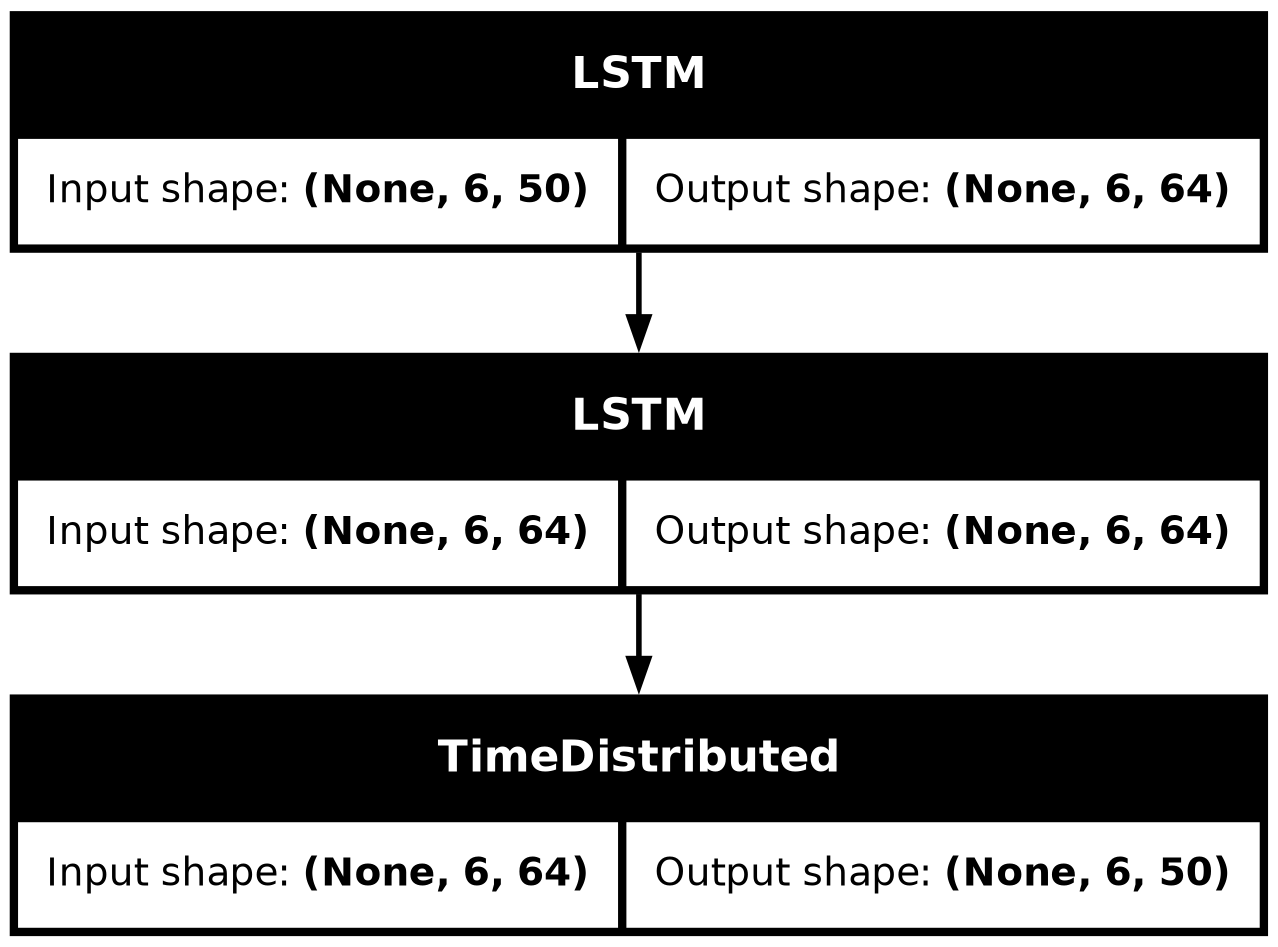

In [50]:
#@title Create LSTM model
numberOfUnits = 64
model_LSTM = Sequential(name='model_LSTM')
model_LSTM.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()
plot_model(model_LSTM,show_shapes=True)

In [51]:
#@title Train and Evaluate LSTM model
trained_model_lstm, history_lstm = train_test(model_LSTM, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 10s - 18ms/step - accuracy: 0.1559 - loss: 3.1514 - val_accuracy: 0.1815 - val_loss: 2.8530
Epoch 2/100
563/563 - 5s - 9ms/step - accuracy: 0.1849 - loss: 2.7822 - val_accuracy: 0.1896 - val_loss: 2.7519
Epoch 3/100
563/563 - 5s - 9ms/step - accuracy: 0.1998 - loss: 2.6894 - val_accuracy: 0.2081 - val_loss: 2.6626
Epoch 4/100
563/563 - 5s - 9ms/step - accuracy: 0.2349 - loss: 2.5919 - val_accuracy: 0.2613 - val_loss: 2.5525
Epoch 5/100
563/563 - 5s - 9ms/step - accuracy: 0.3110 - loss: 2.4599 - val_accuracy: 0.3501 - val_loss: 2.3978
Epoch 6/100
563/563 - 5s - 9ms/step - accuracy: 0.3855 - loss: 2.3171 - val_accuracy: 0.4122 - val_loss: 2.2620
Epoch 7/100
563/563 - 5s - 9ms/step - accuracy: 0.4360 - loss: 2.2033 - val_accuracy: 0.4496 - val_loss: 2.1656
Epoch 8/100
563/563 - 5s - 9ms/step - accuracy: 0.4698 - loss: 2.1168 - val_accuracy: 0.4735 - val_los

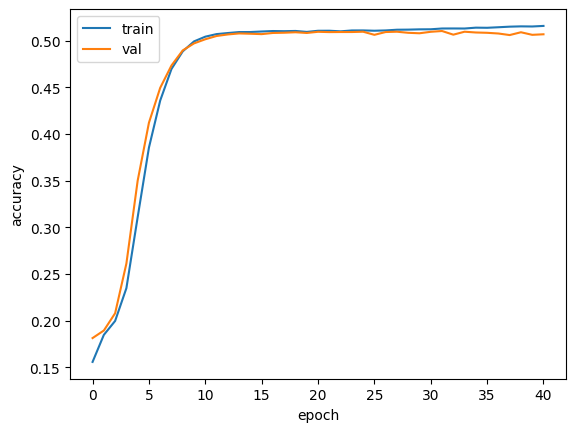

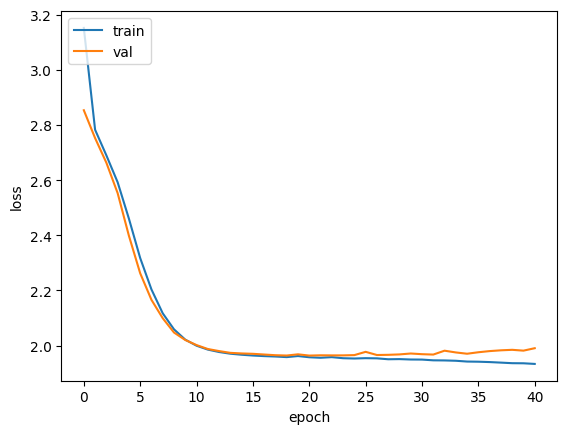

In [52]:
#@title Visualize training and validation LSTM model
visualize_history(history_lstm)

In [53]:
#@title Check random samples LSTM model
check_samples(trained_model_lstm, X_test, y_test, word_array, num_samples=10)

Input: orange guitar mountain strawberry bird park 
Expected: park bird strawberry mountain guitar orange 
Predicted: orange guitar park mountain guitar orange 
False

Input: desert car motorcycle lily tulip strawberry 
Expected: strawberry tulip lily motorcycle car desert 
Predicted: desert orange bus motorcycle car desert 
False

Input: piano tomato guitar train cucumber carrot 
Expected: carrot cucumber train guitar tomato piano 
Predicted: piano rose guitar guitar tomato piano 
False

Input: banana green dog violin piano motorcycle 
Expected: motorcycle piano violin dog green banana 
Predicted: banana elephant car dog green banana 
False

Input: bus beach tulip Tokyo sunflower car 
Expected: car sunflower Tokyo tulip beach bus 
Predicted: bus red London tulip beach bus 
False

Input: dog park table trumpet trumpet Paris 
Expected: Paris trumpet trumpet table park dog 
Predicted: dog orange blue table park dog 
False

Input: computer train rose elephant Sydney potato 
Expected: pota

#3. Information Sharing between RNN Layers

#3.1. LSTM model - Only last hidden state



Model: "model_LSTM_with_last_hidden"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 6, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 6, 50)          │         3,250 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,714 (256.70 KB)

 Trainable params: 65,714 (256.70 KB)

 Non-trainable params: 0 (0.00 B)

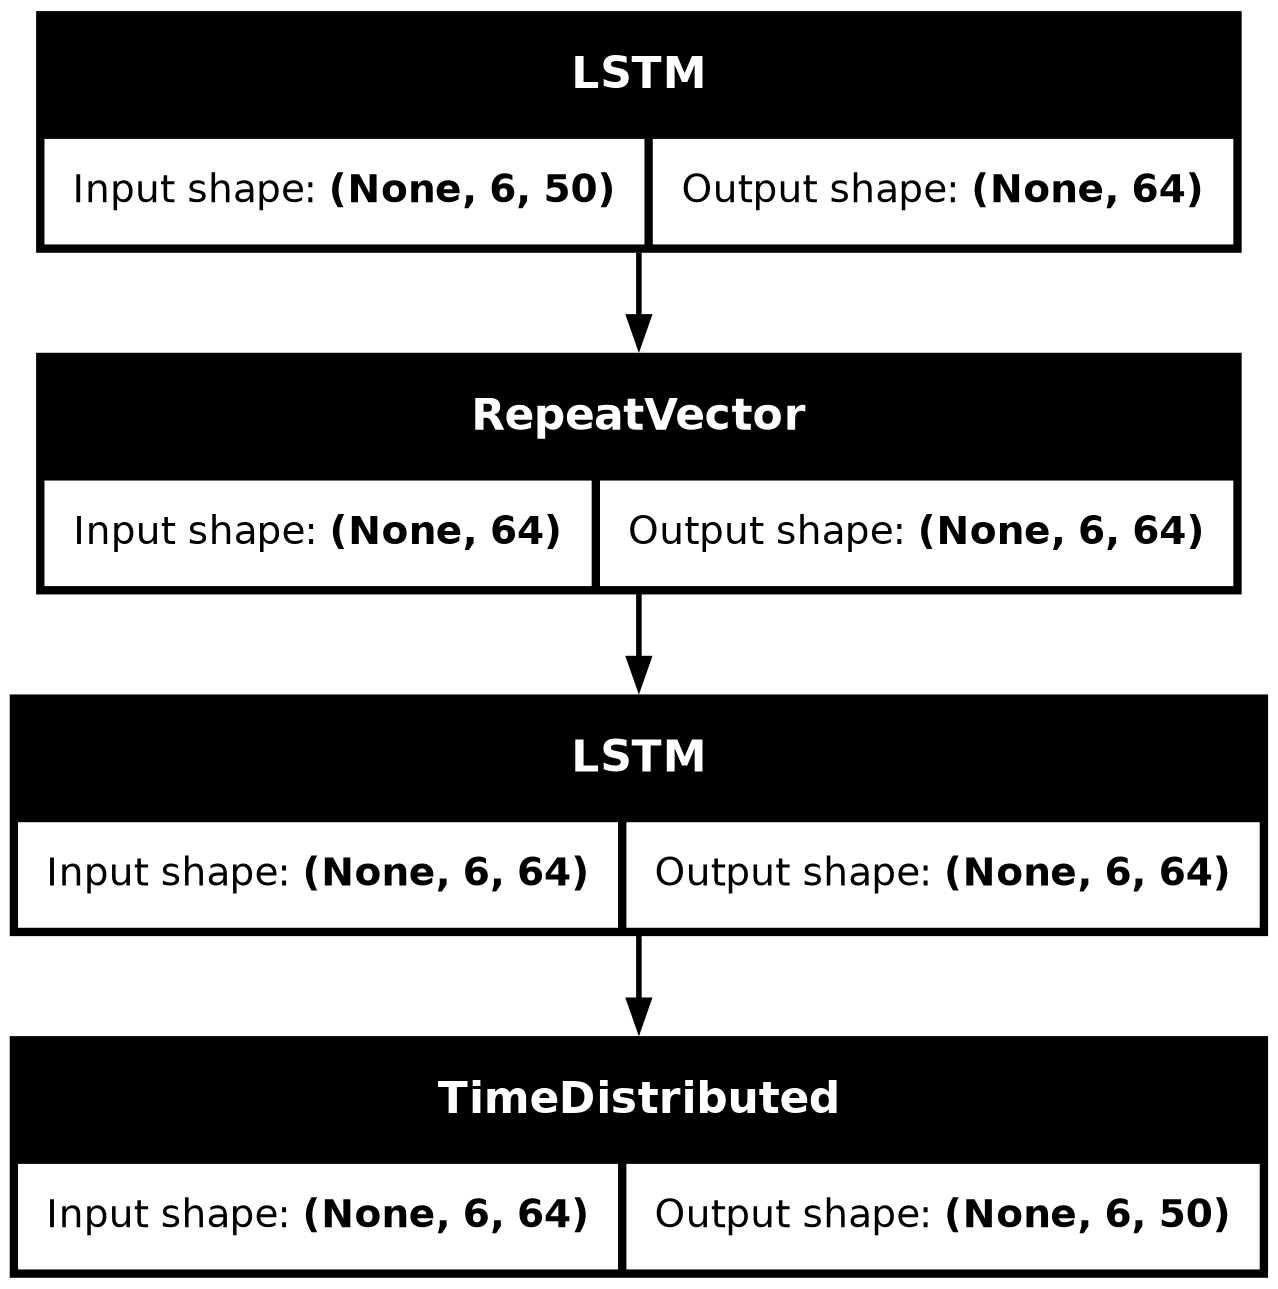

In [54]:
#@title Create LSTM model with only last hidden state
numberOfUnits = 64
model_LSTM_with_last_hidden = Sequential(name='model_LSTM_with_last_hidden')
model_LSTM_with_last_hidden.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits, return_sequences=True)) # Return sequences for TimeDistributed
model_LSTM_with_last_hidden.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_LSTM_with_last_hidden.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden.summary()
plot_model(model_LSTM_with_last_hidden,show_shapes=True)

In [55]:
#@title Train and Evaluate LSTM model with only last hidden state
trained_model_with_last_hidden, history_with_last_hidden = train_test(model_LSTM_with_last_hidden, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 10s - 18ms/step - accuracy: 0.1781 - loss: 2.9473 - val_accuracy: 0.2161 - val_loss: 2.5294
Epoch 2/100
563/563 - 5s - 9ms/step - accuracy: 0.2386 - loss: 2.3674 - val_accuracy: 0.2722 - val_loss: 2.2281
Epoch 3/100
563/563 - 5s - 9ms/step - accuracy: 0.3218 - loss: 2.0591 - val_accuracy: 0.3620 - val_loss: 1.9417
Epoch 4/100
563/563 - 5s - 10ms/step - accuracy: 0.4156 - loss: 1.7693 - val_accuracy: 0.4484 - val_loss: 1.6860
Epoch 5/100
563/563 - 5s - 9ms/step - accuracy: 0.4974 - loss: 1.5243 - val_accuracy: 0.5202 - val_loss: 1.4613
Epoch 6/100
563/563 - 5s - 10ms/step - accuracy: 0.5689 - loss: 1.3207 - val_accuracy: 0.5852 - val_loss: 1.2781
Epoch 7/100
563/563 - 5s - 9ms/step - accuracy: 0.6348 - loss: 1.1345 - val_accuracy: 0.6492 - val_loss: 1.0985
Epoch 8/100
563/563 - 5s - 9ms/step - accuracy: 0.6966 - loss: 0.9675 - val_accuracy: 0.7001 - val_l

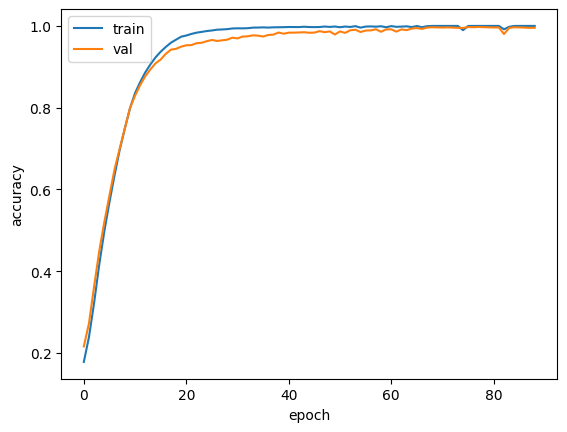

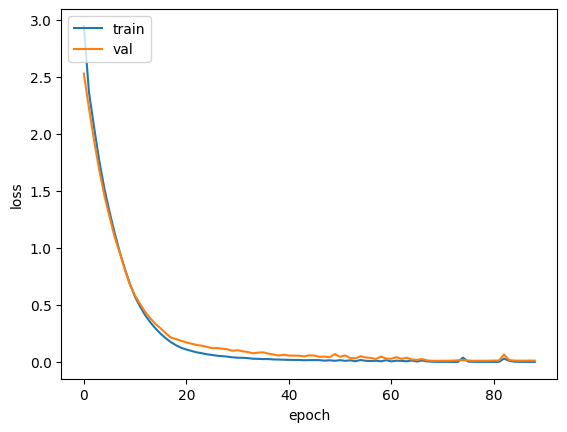

In [56]:
#@title Visualize training and validation LSTM model with only last hidden state
visualize_history(history_with_last_hidden)

In [57]:
#@title Check random samples LSTM model with only last hidden state
check_samples(trained_model_with_last_hidden, X_test, y_test, word_array, num_samples=10)

Input: island red car train cat beach 
Expected: beach cat train car red island 
Predicted: beach cat train car red island 
True

Input: banana orange trumpet red book desert 
Expected: desert book red trumpet orange banana 
Predicted: desert book red trumpet orange banana 
True

Input: train elephant bicycle carrot park tulip 
Expected: tulip park carrot bicycle elephant train 
Predicted: tulip park carrot bicycle elephant train 
True

Input: computer train rose elephant Sydney potato 
Expected: potato Sydney elephant rose train computer 
Predicted: potato Sydney elephant rose train computer 
True

Input: yellow lily carrot chair orange chair 
Expected: chair orange chair carrot lily yellow 
Predicted: chair orange chair carrot lily yellow 
True

Input: red train bus bird Tokyo London 
Expected: London Tokyo bird bus train red 
Predicted: London Tokyo bird bus train red 
True

Input: orange table apple park orange motorcycle 
Expected: motorcycle orange park apple table orange 
Predic

#3.2. LSTM model - Last hidden state and last cell state

Model: "model_LSTM_with_last_hidden_and_last_cell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 6, 50)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 64),      │     29,440 │ input_layer_12[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 6, 64)     │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 6, 64)     │     33,024 │ repeat_vector_3[… │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 6, 50)     │      3,250 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,714 (256.70 KB)

 Trainable params: 65,714 (256.70 KB)

 Non-trainable params: 0 (0.00 B)

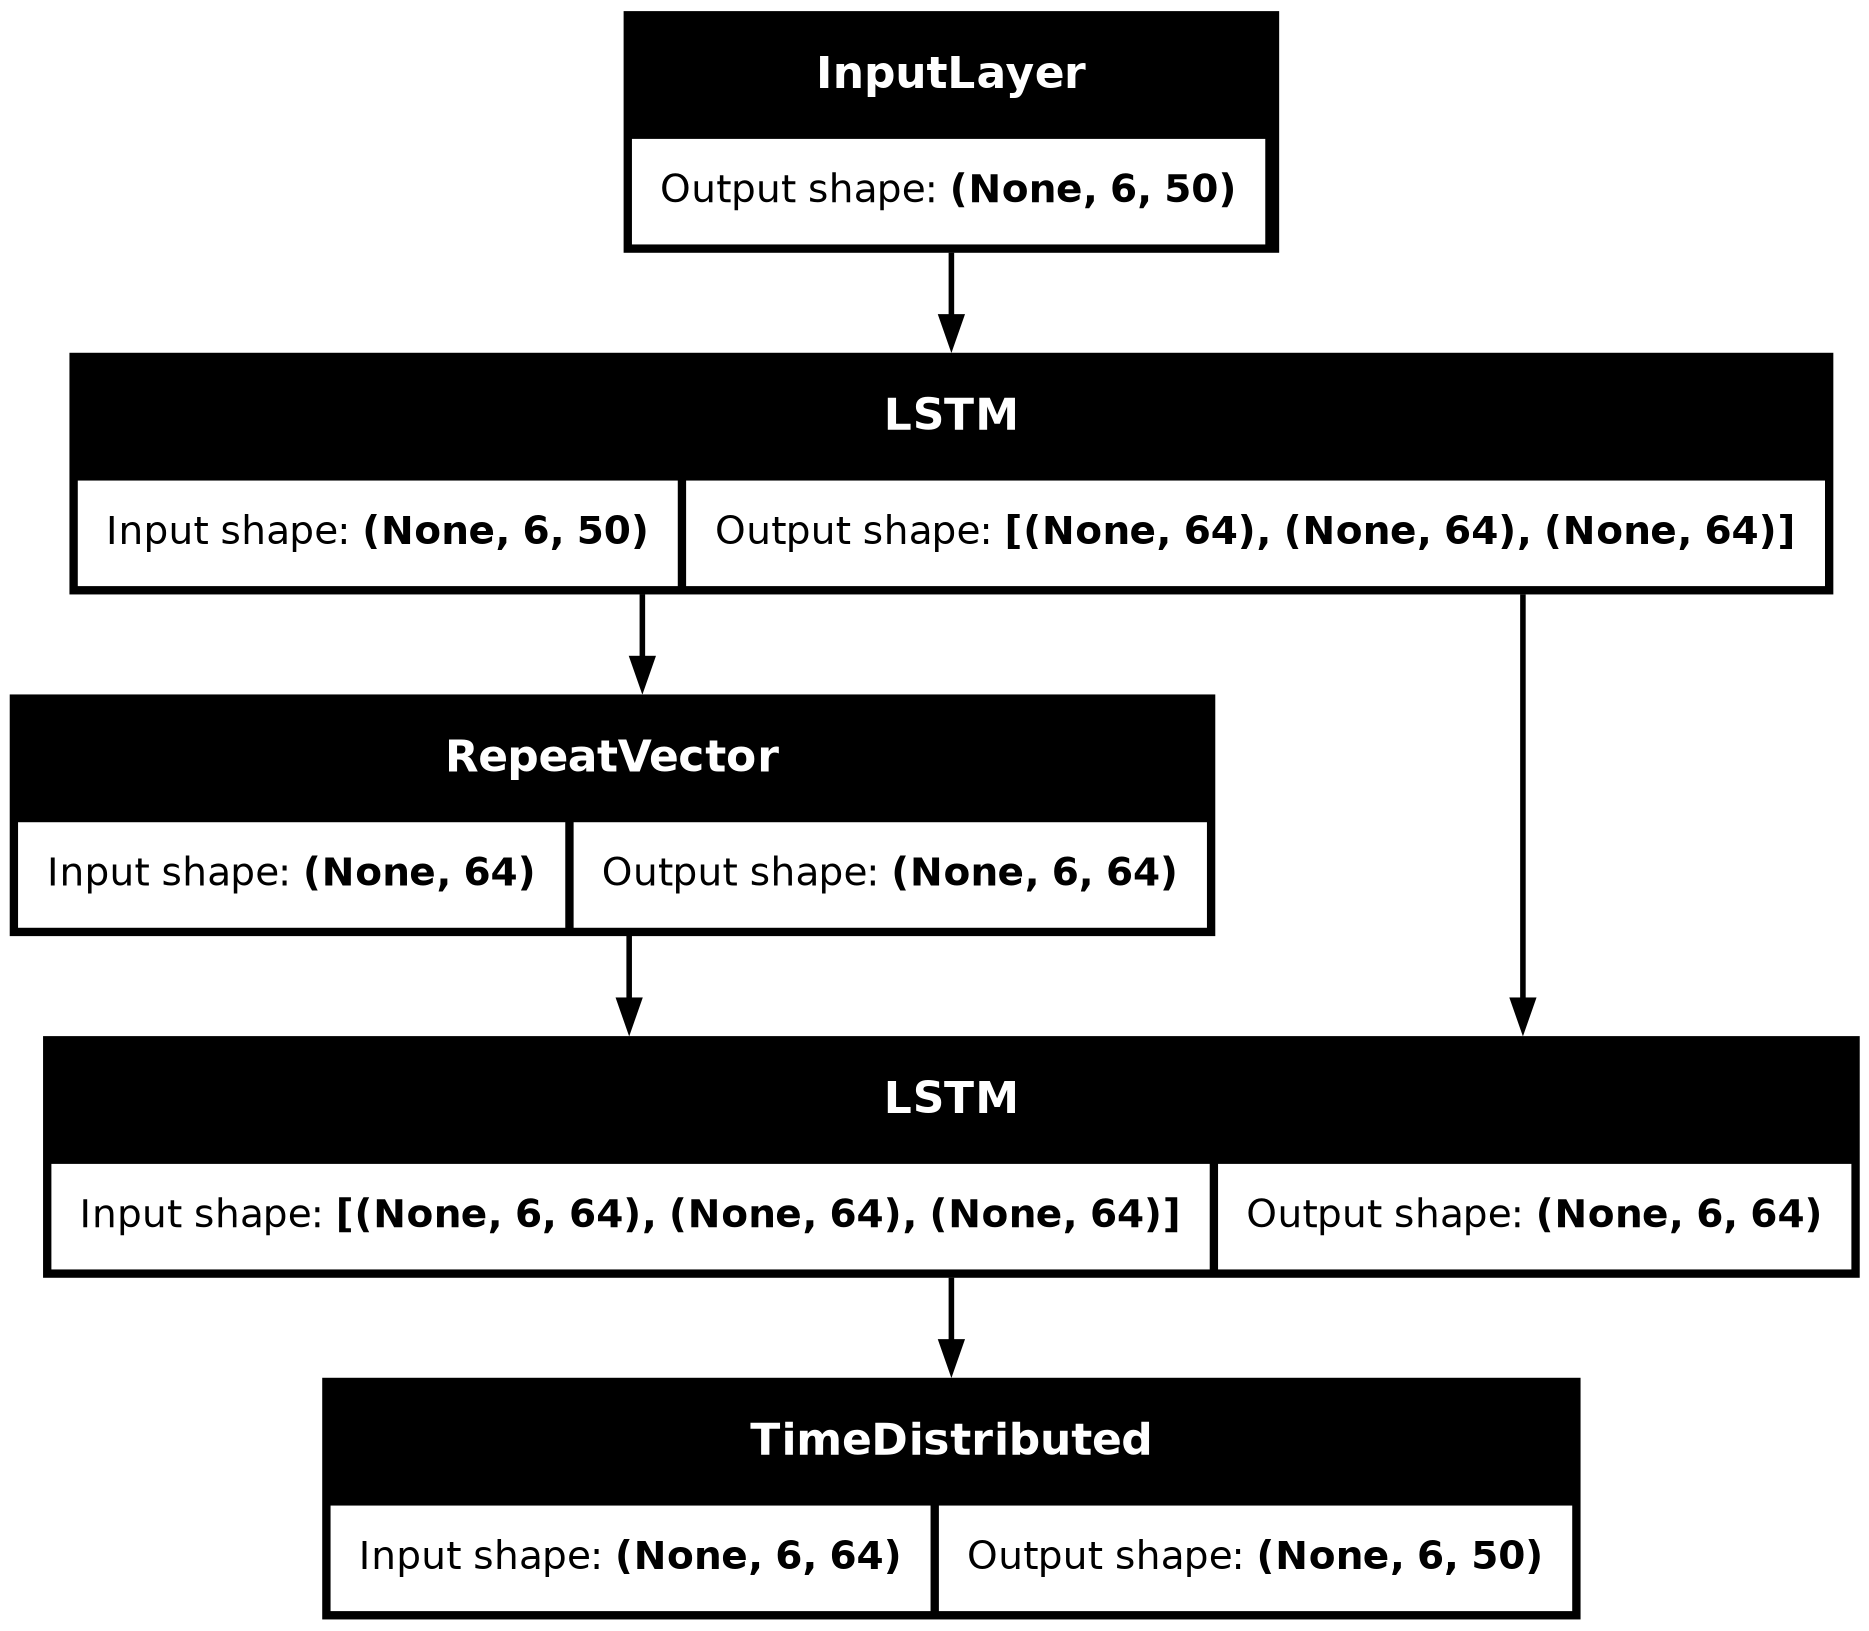

In [58]:
#@title Create LSTM model with last hidden state and last cell state
numberOfUnits = 64
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input)
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps_in)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_last_hidden_and_last_cell = Model(input,output,name='model_LSTM_with_last_hidden_and_last_cell')
model_LSTM_with_last_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_last_hidden_and_last_cell,show_shapes=True)

In [59]:
#@title Train and Evaluate LSTM model with last hidden state and last cell state
trained_model_with_last_hidden_and_last_cell, history_with_last_hidden_and_last_cell = train_test(model_LSTM_with_last_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 9s - 16ms/step - accuracy: 0.1935 - loss: 2.8608 - val_accuracy: 0.2375 - val_loss: 2.3966
Epoch 2/100
563/563 - 5s - 9ms/step - accuracy: 0.2875 - loss: 2.1599 - val_accuracy: 0.3456 - val_loss: 1.9542
Epoch 3/100
563/563 - 5s - 9ms/step - accuracy: 0.4084 - loss: 1.7337 - val_accuracy: 0.4531 - val_loss: 1.5859
Epoch 4/100
563/563 - 5s - 9ms/step - accuracy: 0.5159 - loss: 1.4029 - val_accuracy: 0.5581 - val_loss: 1.2958
Epoch 5/100
563/563 - 5s - 9ms/step - accuracy: 0.6100 - loss: 1.1405 - val_accuracy: 0.6378 - val_loss: 1.0618
Epoch 6/100
563/563 - 5s - 9ms/step - accuracy: 0.6907 - loss: 0.9296 - val_accuracy: 0.7087 - val_loss: 0.8913
Epoch 7/100
563/563 - 5s - 9ms/step - accuracy: 0.7532 - loss: 0.7658 - val_accuracy: 0.7563 - val_loss: 0.7528
Epoch 8/100
563/563 - 5s - 9ms/step - accuracy: 0.8008 - loss: 0.6351 - val_accuracy: 0.7946 - val_loss

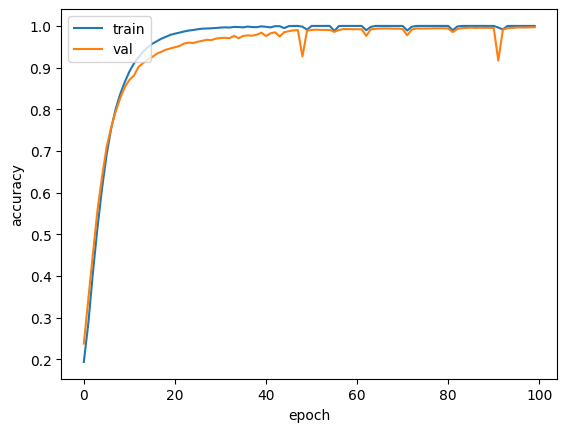

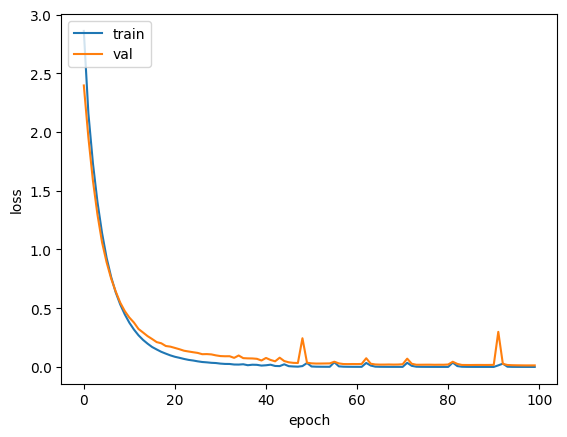

In [60]:
#@title Visualize training and validation LSTM model with last hidden state and last cell state
visualize_history(history_with_last_hidden_and_last_cell)

In [61]:
#@title Check random samples LSTM model with last hidden state and last cell state
check_samples(trained_model_with_last_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: sunflower broccoli carrot tulip Paris tulip 
Expected: tulip Paris tulip carrot broccoli sunflower 
Predicted: tulip Paris tulip carrot broccoli sunflower 
True

Input: yellow table tulip dog bird tulip 
Expected: tulip bird dog tulip table yellow 
Predicted: tulip bird dog tulip table yellow 
True

Input: island bicycle book tulip red purple 
Expected: purple red tulip book bicycle island 
Predicted: purple red tulip book bicycle island 
True

Input: tulip daisy strawberry cucumber strawberry desert 
Expected: desert strawberry cucumber strawberry daisy tulip 
Predicted: desert strawberry cucumber strawberry daisy tulip 
True

Input: Colombo green table yellow violin piano 
Expected: piano violin yellow table green Colombo 
Predicted: piano violin yellow table green Colombo 
True

Input: motorcycle violin Paris rose cat cucumber 
Expected: cucumber cat rose Paris violin motorcycle 
Predicted: cucumber cat rose Paris violin motorcycle 
True

Input: park apple flute yellow elepha

#3.3. LSTM model - All hidden states and last cell state

Model: "model_LSTM_with_all_hidden_and_last_cell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 6, 50)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 6, 64),   │     29,440 │ input_layer_13[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 6, 64)     │     33,024 │ lstm_14[0][0],    │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 6, 50)     │      3,250 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,714 (256.70 KB)

 Trainable params: 65,714 (256.70 KB)

 Non-trainable params: 0 (0.00 B)

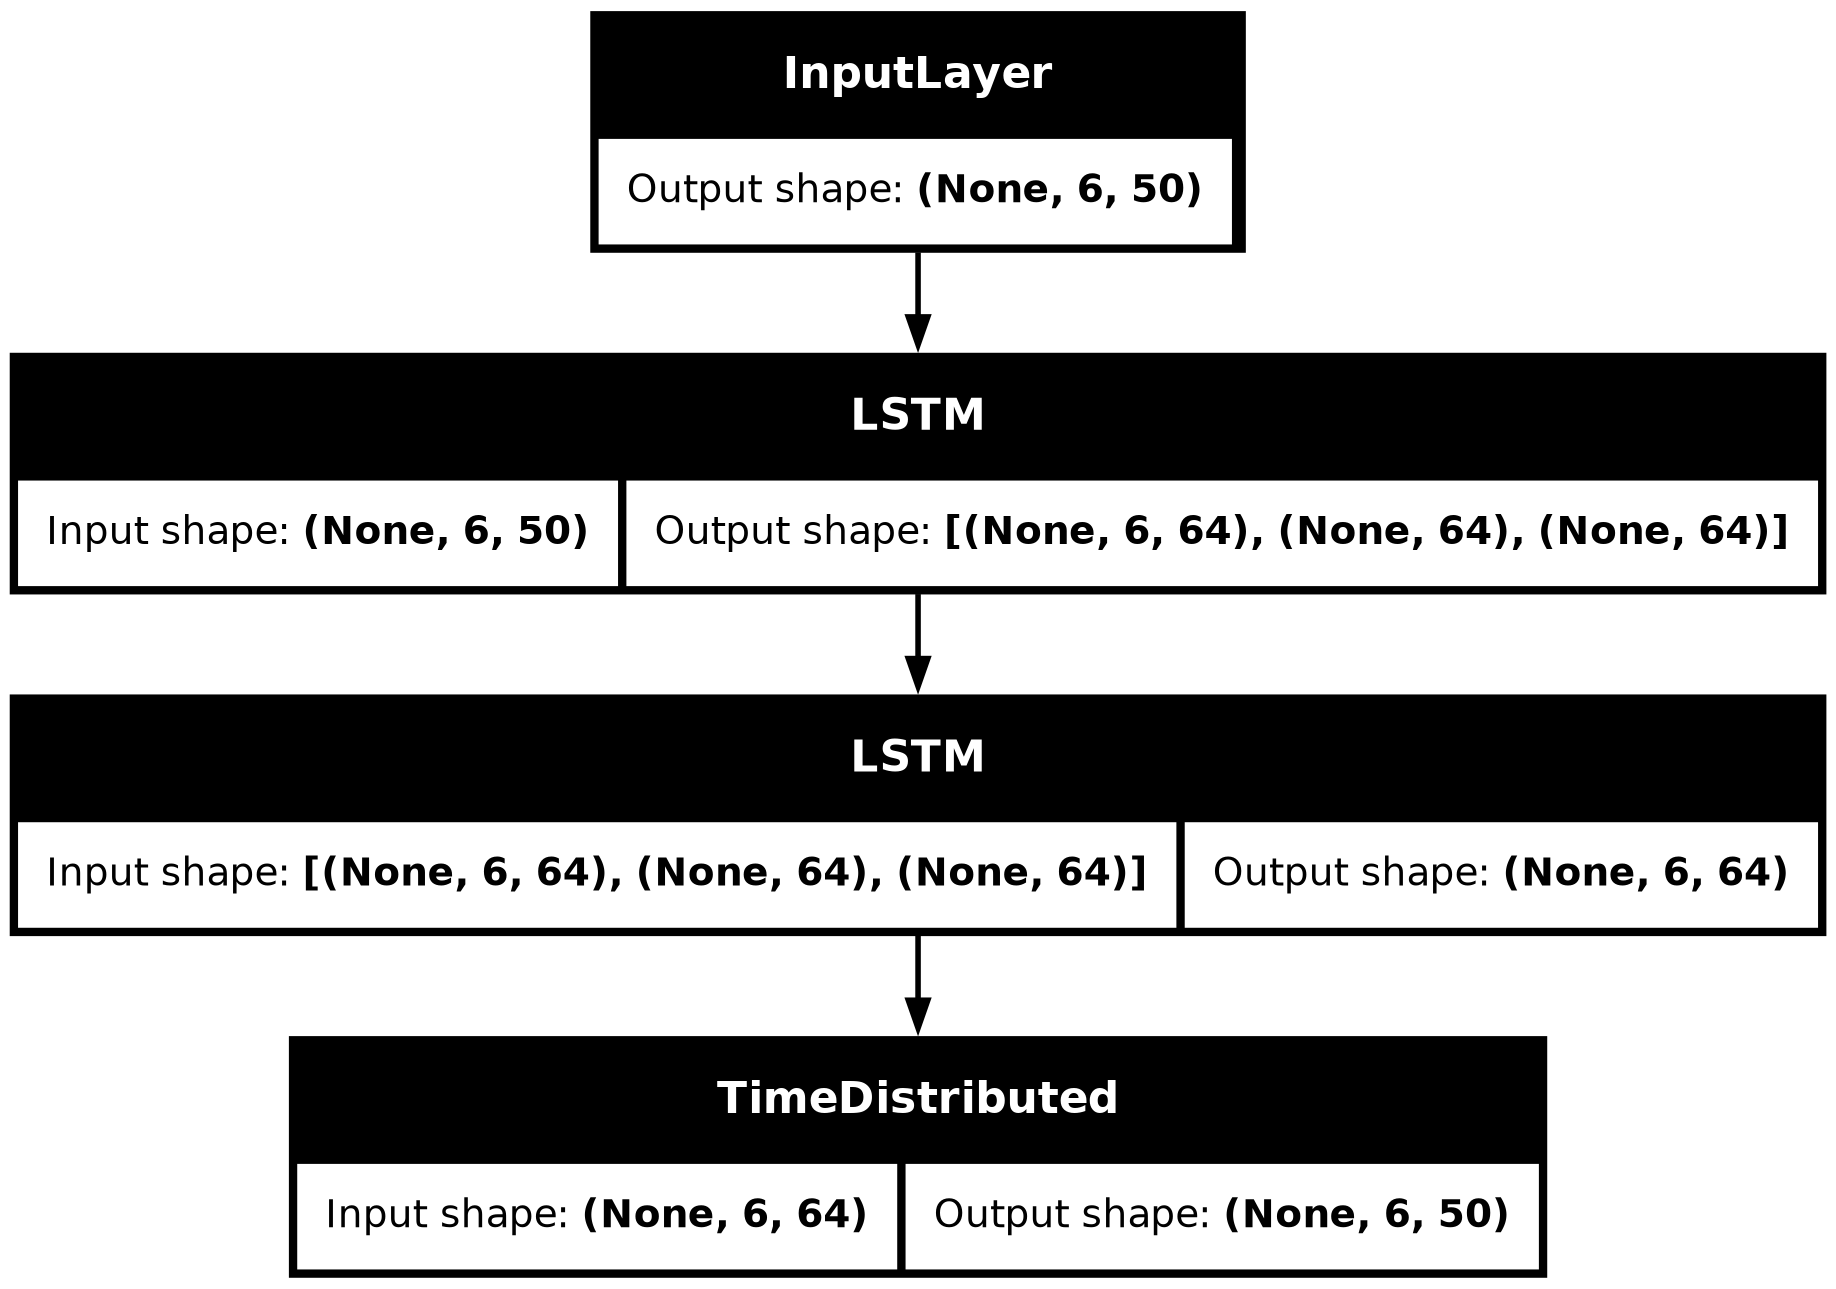

In [62]:
#@title Create LSTM model with all hidden states and last cell state
numberOfUnits = 64
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input)
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_all_hidden_and_last_cell = Model(input,output, name='model_LSTM_with_all_hidden_and_last_cell')
model_LSTM_with_all_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_all_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_all_hidden_and_last_cell,show_shapes=True)

In [63]:
#@title Train and Evaluate LSTM model with all hidden states and last cell state
trained_model_with_all_hidden_and_last_cell, history_with_all_hidden_and_last_cell = train_test(model_LSTM_with_all_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 9s - 16ms/step - accuracy: 0.1959 - loss: 2.8313 - val_accuracy: 0.2402 - val_loss: 2.3590
Epoch 2/100
563/563 - 5s - 9ms/step - accuracy: 0.3019 - loss: 2.0967 - val_accuracy: 0.3593 - val_loss: 1.8674
Epoch 3/100
563/563 - 5s - 8ms/step - accuracy: 0.4241 - loss: 1.6421 - val_accuracy: 0.4728 - val_loss: 1.4978
Epoch 4/100
563/563 - 5s - 9ms/step - accuracy: 0.5280 - loss: 1.3288 - val_accuracy: 0.5701 - val_loss: 1.2385
Epoch 5/100
563/563 - 5s - 9ms/step - accuracy: 0.6241 - loss: 1.0827 - val_accuracy: 0.6558 - val_loss: 1.0095
Epoch 6/100
563/563 - 5s - 9ms/step - accuracy: 0.7065 - loss: 0.8780 - val_accuracy: 0.7315 - val_loss: 0.8265
Epoch 7/100
563/563 - 5s - 9ms/step - accuracy: 0.7710 - loss: 0.7105 - val_accuracy: 0.7804 - val_loss: 0.6845
Epoch 8/100
563/563 - 5s - 9ms/step - accuracy: 0.8191 - loss: 0.5779 - val_accuracy: 0.8176 - val_loss

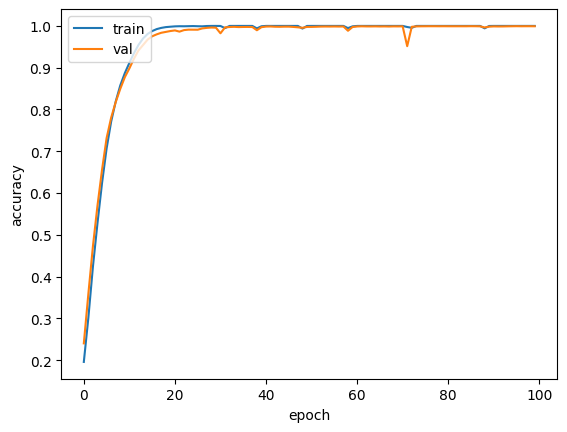

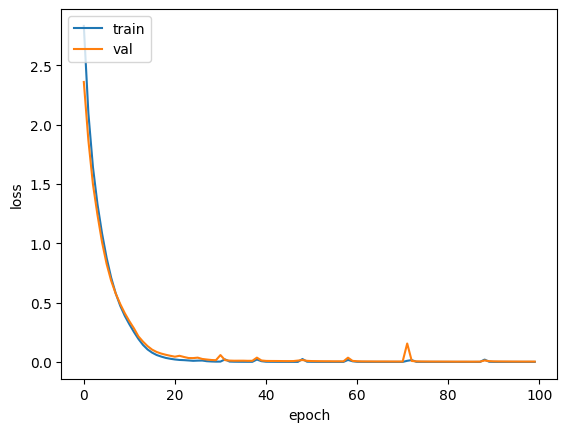

In [64]:
#@title Visualize training and validation LSTM model with all hidden states and last cell state
visualize_history(history_with_all_hidden_and_last_cell)

In [65]:
#@title Check random samples LSTM model with all hidden states and last cell state
check_samples(trained_model_with_all_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: bicycle lamp carrot dog violin purple 
Expected: purple violin dog carrot lamp bicycle 
Predicted: purple violin dog carrot lamp bicycle 
True

Input: cat apple Paris cat motorcycle bus 
Expected: bus motorcycle cat Paris apple cat 
Predicted: bus motorcycle cat Paris apple cat 
True

Input: table table bird green tulip cat 
Expected: cat tulip green bird table table 
Predicted: cat tulip green bird table table 
True

Input: daisy desert elephant sunflower park computer 
Expected: computer park sunflower elephant desert daisy 
Predicted: computer park sunflower elephant desert daisy 
True

Input: Colombo lily rose apple London lily 
Expected: lily London apple rose lily Colombo 
Predicted: lily London apple rose lily Colombo 
True

Input: rose dog trumpet lion book beach 
Expected: beach book lion trumpet dog rose 
Predicted: beach book lion trumpet dog rose 
True

Input: cucumber mountain cherry island cherry apple 
Expected: apple cherry island cherry mountain cucumber 
Predic

#Reference
1. https://www.muratkarakaya.net/2022/11/seq2seq-learning-tutorial-series.html
2. https://deeplearningmath.org/sequence-models.html
